# Task
Fine-tune a DistilGPT2 model for SMS spam detection using the `uciml/sms-spam-collection-dataset` from Kaggle, and then demonstrate its inference capabilities.

## Setup and Data Loading

### Subtask:
Install necessary libraries (transformers, datasets, pandas, scikit-learn) and download/load the uciml/sms-spam-collection-dataset from Kaggle. Display the first few rows and basic statistics of the dataset.


**Reasoning**:
First, I will install all the necessary libraries for the subtask, including transformers, datasets, pandas, scikit-learn, and kaggle.



In [5]:
pip install transformers datasets pandas scikit-learn kaggle

## Configure Kaggle API with Environment Variables

### Subtask:
Set up Kaggle API credentials by uploading `kaggle.json` and configuring environment variables.


In [6]:
import os
import json

os.environ['KAGGLE_USERNAME'] = 'piyueshkumar'
os.environ['KAGGLE_KEY'] = '91ec945b09ef34b522f2dbb98a55489e'

## Download and Unzip Dataset

### Subtask:
Download the `uciml/sms-spam-collection-dataset` from Kaggle using the `kaggle` CLI (which will now use the environment variables for authentication) and unzip the downloaded file.


In [7]:
import os

# Download the dataset from Kaggle
!kaggle datasets download -d uciml/sms-spam-collection-dataset

# Unzip the downloaded file, overwriting existing files without prompting
!unzip -o sms-spam-collection-dataset.zip
print("Dataset downloaded and unzipped.")

Dataset URL: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset
License(s): unknown
  0% 0.00/211k [00:00<?, ?B/s]
100% 211k/211k [00:00<00:00, 542MB/s]
Archive:  sms-spam-collection-dataset.zip
  inflating: spam.csv                
Dataset downloaded and unzipped.


In [8]:
import pandas as pd

# Load the dataset into a pandas DataFrame
df = pd.read_csv('spam.csv', encoding='latin-1')

# Display the first few rows
print("First 5 rows of the dataset:")
print(df.head())

# Display basic statistics
print("\nBasic statistics of the dataset:")
print(df.info())
print("\nDescriptive statistics for numerical columns:")
print(df.describe(include='all'))

First 5 rows of the dataset:
     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  

Basic statistics of the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     obj

## Data Preprocessing

### Subtask:
Clean and preprocess the text data. Tokenize the SMS messages using the DistilGPT2 tokenizer and create numerical labels (0 for ham, 1 for spam). Split the dataset into training and validation/test sets.


**Reasoning**:
First, I will clean the dataframe by dropping irrelevant columns, renaming the remaining ones for clarity, and converting the categorical labels 'ham' and 'spam' into numerical format (0 and 1 respectively) as required for model training.



In [9]:
import pandas as pd

# Drop the irrelevant columns
df = df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])

# Rename columns for clarity
df = df.rename(columns={'v1': 'label', 'v2': 'text'})

# Convert 'label' column to numerical format (0 for ham, 1 for spam)
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

print("DataFrame after cleaning and renaming:")
print(df.head())
print("\nValue counts for the label column:")
print(df['label'].value_counts())


DataFrame after cleaning and renaming:
   label                                               text
0      0  Go until jurong point, crazy.. Available only ...
1      0                      Ok lar... Joking wif u oni...
2      1  Free entry in 2 a wkly comp to win FA Cup fina...
3      0  U dun say so early hor... U c already then say...
4      0  Nah I don't think he goes to usf, he lives aro...

Value counts for the label column:
label
0    4825
1     747
Name: count, dtype: int64


In [11]:
from transformers import GPT2Tokenizer
from datasets import Dataset
from sklearn.model_selection import train_test_split

# Load the DistilGPT2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('distilgpt2')

# Add a padding token if not already present
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': tokenizer.eos_token})

# Define a preprocessing function
def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=128)

# Convert pandas DataFrame to Hugging Face Dataset
hf_dataset = Dataset.from_pandas(df)

# Apply the preprocessing function
tokenized_datasets = hf_dataset.map(tokenize_function, batched=True)

# Remove the original text column and other unnecessary columns if present
tokenized_datasets = tokenized_datasets.remove_columns(['text'])

# Rename 'label' to 'labels' for compatibility with Hugging Face models
tokenized_datasets = tokenized_datasets.rename_column('label', 'labels')

# Split the dataset into training and validation/test sets (80% train, 20% validation/test)
train_test_split_dataset = tokenized_datasets.train_test_split(test_size=0.2, seed=42)

# Further split the test set into validation and test sets (10% validation, 10% test)
# This is done by splitting the 20% test_size into two halves
validation_test_split = train_test_split_dataset['test'].train_test_split(test_size=0.5, seed=42)

train_dataset = train_test_split_dataset['train']
validation_dataset = validation_test_split['train']
test_dataset = validation_test_split['test']

print("Tokenizer loaded and preprocessing function defined.")
print("Dataset converted to Hugging Face Dataset format.")
print("Dataset split into training, validation, and test sets.")

print(f"\nTraining dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(validation_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

print("\nFirst entry of the tokenized training dataset:")
print(train_dataset[0])

Map:   0%|          | 0/5572 [00:00<?, ? examples/s]

Tokenizer loaded and preprocessing function defined.
Dataset converted to Hugging Face Dataset format.
Dataset split into training, validation, and test sets.

Training dataset size: 4457
Validation dataset size: 557
Test dataset size: 558

First entry of the tokenized training dataset:
{'labels': 0, 'input_ids': [5840, 1671, 342, 492, 9937, 16998, 492, 4164, 334, 287, 610, 403, 288, 3099, 1667, 81, 469, 492, 2787, 368, 1671, 30, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,

## Model Loading and Configuration

### Subtask:
Load the pre-trained DistilGPT2 model and its corresponding tokenizer from Hugging Face. Adapt the model for sequence classification by adding a classification head suitable for binary classification (spam/ham).


**Reasoning**:
I will load the pre-trained DistilGPT2 model for sequence classification and configure it for binary classification by setting the number of labels and the padding token ID.



In [12]:
from transformers import AutoModelForSequenceClassification

# Load the pre-trained DistilGPT2 model for sequence classification
# Set num_labels to 2 for binary classification (ham/spam)
model = AutoModelForSequenceClassification.from_pretrained('distilgpt2', num_labels=2)

# Set the model's padding token ID to the tokenizer's padding token ID
# This ensures consistency during inference and training, as DistilGPT2 doesn't have a default pad_token_id
model.config.pad_token_id = tokenizer.pad_token_id

print("DistilGPT2 model loaded and configured for binary sequence classification.")

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilGPT2 model loaded and configured for binary sequence classification.


## Evaluation Before Fine-tuning

### Subtask:
Evaluate the model's performance on the test set before fine-tuning to establish a baseline.


In [14]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import TrainingArguments, Trainer

# 2. Define a function named compute_metrics
def compute_metrics(pred):
    labels = pred.label_ids
    predictions = pred.predictions.argmax(-1)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# 4. Initialize TrainingArguments for evaluation
# We only need output_dir and per_device_eval_batch_size for evaluation here
eval_args = TrainingArguments(
    output_dir='./baseline_results',
    per_device_eval_batch_size=8,
    # Other training arguments like num_train_epochs, learning_rate etc. are not needed for a simple evaluation
)

# 6. Initialize a Trainer instance
baseline_trainer = Trainer(
    model=model,
    args=eval_args,
    eval_dataset=test_dataset, # Evaluate on the test dataset
    compute_metrics=compute_metrics,
)

# 7. Call trainer.evaluate() to get the baseline evaluation results and print them
print("\nEvaluating baseline model performance on the test set...")
baseline_metrics = baseline_trainer.evaluate()
print("Baseline Model Evaluation Results:")
print(baseline_metrics)



Evaluating baseline model performance on the test set...


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: oaisys (oaisys-theoaisys) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Baseline Model Evaluation Results:
{'eval_loss': 0.9012208580970764, 'eval_model_preparation_time': 0.0022, 'eval_accuracy': 0.8566308243727598, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 4.3208, 'eval_samples_per_second': 129.144, 'eval_steps_per_second': 16.201}


In [15]:
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding

# 1. Define TrainingArguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,               # Total number of training epochs
    per_device_train_batch_size=16,   # Batch size per device during training
    per_device_eval_batch_size=16,    # Batch size for evaluation
    warmup_steps=500,                 # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,                # Strength of weight decay
    logging_dir='./logs',             # Directory for storing logs
    logging_steps=10,
    eval_strategy="epoch",          # Evaluate the model at the end of each epoch
    save_strategy="epoch",            # Save the model checkpoint at the end of each epoch
    load_best_model_at_end=True,      # Load the best model after training
    metric_for_best_model="f1",       # Use F1 score to determine the best model
    report_to="none" # Disable integration with Weights & Biases
)

# Data collator for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# 2. Initialize a Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset, # Use validation_dataset for evaluation during training
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# 3. Train the model
print("Starting model training...")
trainer.train()
print("Model training complete.")

Starting model training...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.080500,0.018418,0.992819,0.968254,1.000000,0.938462
2,0.000700,0.039922,0.992819,0.968750,0.984127,0.953846
3,0.048600,0.013784,0.996409,0.984615,0.984615,0.984615


Model training complete.


## Demonstrate Inference

### Subtask:
Fine-tuned model to predict whether new, unseen SMS messages are 'ham' or 'spam'.

**Reasoning**:
The model has been fine-tuned. The next step is to evaluate its performance on the test set and compare these metrics (accuracy, precision, recall, F1-score) with the `baseline_metrics` obtained before fine-tuning to demonstrate the improvement.

In [19]:
import torch

# Function to predict if an SMS is spam or ham
def predict_spam(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=128)
    # Move input tensors to the same device as the model
    inputs = {key: value.to(model.device) for key, value in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=-1)
    predicted_class = torch.argmax(probabilities, dim=-1).item()

    return "spam" if predicted_class == 1 else "ham", probabilities[0][predicted_class].item()

# Test cases
test_messages = [
    "Congratulations! You've won a \$1,000 gift card! Claim your prize now.",
    "Hey, just wanted to check in and see how you're doing. Long time no talk!",
    "URGENT! Your mobile number has been selected for a free prize. Call 09061701461 now!",
    "Can we meet tomorrow for lunch?",
    "WINNER! Your account has been credited with 1000 bonus points. Visit link to activate.",
    "Hi, how are you?",
]

print("\n--- Inference Examples ---")
for message in test_messages:
    prediction, probability = predict_spam(message)
    print(f"SMS: \"{message}\"")
    print(f"Prediction: {prediction} (Probability: {probability:.4f})\n")



--- Inference Examples ---
SMS: "Congratulations! You've won a \$1,000 gift card! Claim your prize now."
Prediction: spam (Probability: 0.9994)

SMS: "Hey, just wanted to check in and see how you're doing. Long time no talk!"
Prediction: ham (Probability: 1.0000)

SMS: "URGENT! Your mobile number has been selected for a free prize. Call 09061701461 now!"
Prediction: spam (Probability: 1.0000)

SMS: "Can we meet tomorrow for lunch?"
Prediction: ham (Probability: 0.9998)

SMS: "WINNER! Your account has been credited with 1000 bonus points. Visit link to activate."
Prediction: spam (Probability: 0.9999)

SMS: "Hi, how are you?"
Prediction: ham (Probability: 0.9999)



<>:18: SyntaxWarning: invalid escape sequence '\$'
<>:18: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipython-input-2896514054.py:18: SyntaxWarning: invalid escape sequence '\$'
  "Congratulations! You've won a \$1,000 gift card! Claim your prize now.",


## Demonstrate Inference (Before Fine-tuning)

## Demonstrate Inference (True Baseline Model)

**Reasoning**:
To correct the previous misleading baseline inference, I will now explicitly load a fresh instance of the DistilGPT2 model that has *not* been fine-tuned. This `unfine_tuned_model` will be used for demonstrating inference of the true baseline, allowing for a proper comparison with the fine-tuned model.

In [21]:
from transformers import AutoModelForSequenceClassification

# Load a fresh instance of the pre-trained DistilGPT2 model for baseline inference
# This model has not been fine-tuned on the SMS spam dataset
unfine_tuned_model = AutoModelForSequenceClassification.from_pretrained('distilgpt2', num_labels=2)

# Set the padding token ID for consistency
unfine_tuned_model.config.pad_token_id = tokenizer.pad_token_id

print("Un-fine-tuned DistilGPT2 model loaded for baseline inference.")


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Un-fine-tuned DistilGPT2 model loaded for baseline inference.


In [22]:
import torch

# Function to predict if an SMS is spam or ham using a specified model
def predict_spam_with_model(text, model_to_use):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=128)
    # Move input tensors to the same device as the model
    inputs = {key: value.to(model_to_use.device) for key, value in inputs.items()}
    with torch.no_grad():
        outputs = model_to_use(**inputs)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=-1)
    predicted_class = torch.argmax(probabilities, dim=-1).item()

    return "spam" if predicted_class == 1 else "ham", probabilities[0][predicted_class].item()

print("\n--- Inference Examples (True Baseline Model) ---")
for message in test_messages:
    prediction, probability = predict_spam_with_model(message, unfine_tuned_model)
    print(f"SMS: \"{message}\"")
    print(f"Prediction: {prediction} (Probability: {probability:.4f})\n")



--- Inference Examples (True Baseline Model) ---
SMS: "Congratulations! You've won a \$1,000 gift card! Claim your prize now."
Prediction: ham (Probability: 0.6944)

SMS: "Hey, just wanted to check in and see how you're doing. Long time no talk!"
Prediction: ham (Probability: 0.8011)

SMS: "URGENT! Your mobile number has been selected for a free prize. Call 09061701461 now!"
Prediction: ham (Probability: 0.7117)

SMS: "Can we meet tomorrow for lunch?"
Prediction: ham (Probability: 0.8468)

SMS: "WINNER! Your account has been credited with 1000 bonus points. Visit link to activate."
Prediction: ham (Probability: 0.7652)

SMS: "Hi, how are you?"
Prediction: ham (Probability: 0.7849)



# Task
Evaluate the fine-tuned DistilGPT2 model's performance on the test set, comparing metrics such as accuracy, precision, recall, and F1-score with the previously established baseline to demonstrate improvement.

## Evaluation After Fine-tuning

### Subtask:
Evaluate the fine-tuned model's performance on the test set. Compare these metrics (e.g., accuracy, precision, recall, F1-score) with the baseline evaluation from before fine-tuning to demonstrate improvement.


In [16]:
print("\nEvaluating fine-tuned model performance on the test set...")
fined_tuned_metrics = trainer.evaluate(eval_dataset=test_dataset)
print("Fine-tuned Model Evaluation Results:")
print(fined_tuned_metrics)

print("\n--- Comparison with Baseline Model ---")
print("Baseline Model F1: ", baseline_metrics.get('eval_f1'))
print("Fine-tuned Model F1: ", fined_tuned_metrics.get('eval_f1'))
print("Baseline Model Accuracy: ", baseline_metrics.get('eval_accuracy'))
print("Fine-tuned Model Accuracy: ", fined_tuned_metrics.get('eval_accuracy'))
print("Baseline Model Precision: ", baseline_metrics.get('eval_precision'))
print("Fine-tuned Model Precision: ", fined_tuned_metrics.get('eval_precision'))
print("Baseline Model Recall: ", baseline_metrics.get('eval_recall'))
print("Fine-tuned Model Recall: ", fined_tuned_metrics.get('eval_recall'))

print("\n--- Summary of Improvements ---")
if fined_tuned_metrics.get('eval_f1') > baseline_metrics.get('eval_f1'):
    print(f"F1-score improved from {baseline_metrics.get('eval_f1'):.4f} to {fined_tuned_metrics.get('eval_f1'):.4f}.")
if fined_tuned_metrics.get('eval_accuracy') > baseline_metrics.get('eval_accuracy'):
    print(f"Accuracy improved from {baseline_metrics.get('eval_accuracy'):.4f} to {fined_tuned_metrics.get('eval_accuracy'):.4f}.")
if fined_tuned_metrics.get('eval_precision') > baseline_metrics.get('eval_precision'):
    print(f"Precision improved from {baseline_metrics.get('eval_precision'):.4f} to {fined_tuned_metrics.get('eval_precision'):.4f}.")
if fined_tuned_metrics.get('eval_recall') > baseline_metrics.get('eval_recall'):
    print(f"Recall improved from {baseline_metrics.get('eval_recall'):.4f} to {fined_tuned_metrics.get('eval_recall'):.4f}.")



Evaluating fine-tuned model performance on the test set...


Fine-tuned Model Evaluation Results:
{'eval_loss': 0.048322971910238266, 'eval_accuracy': 0.9910394265232975, 'eval_f1': 0.967741935483871, 'eval_precision': 1.0, 'eval_recall': 0.9375, 'eval_runtime': 2.7027, 'eval_samples_per_second': 206.461, 'eval_steps_per_second': 12.95, 'epoch': 3.0}

--- Comparison with Baseline Model ---
Baseline Model F1:  0.0
Fine-tuned Model F1:  0.967741935483871
Baseline Model Accuracy:  0.8566308243727598
Fine-tuned Model Accuracy:  0.9910394265232975
Baseline Model Precision:  0.0
Fine-tuned Model Precision:  1.0
Baseline Model Recall:  0.0
Fine-tuned Model Recall:  0.9375

--- Summary of Improvements ---
F1-score improved from 0.0000 to 0.9677.
Accuracy improved from 0.8566 to 0.9910.
Precision improved from 0.0000 to 1.0000.
Recall improved from 0.0000 to 0.9375.


## Demonstrate Inference

### Subtask:
Show examples of how to use the fine-tuned model to predict whether new, unseen SMS messages are 'ham' or 'spam'.


## Summary:

### Q&A
Yes, the fine-tuned DistilGPT2 model demonstrated significant improvement in performance on the test set compared to the baseline model across all evaluated metrics.

### Data Analysis Key Findings
*   The fine-tuning process was successfully completed for the DistilGPT2 model on the SMS spam detection dataset.
*   **F1-score** dramatically improved from 0.0000 (baseline) to 0.9677 (fine-tuned).
*   **Accuracy** saw a substantial increase from 0.8566 (baseline) to 0.9910 (fine-tuned).
*   **Precision** improved significantly from 0.0000 (baseline) to 1.0000 (fine-tuned).
*   **Recall** increased from 0.0000 (baseline) to 0.9375 (fine-tuned).
*   The fine-tuned model exhibits high performance, particularly in minimizing false positives (perfect precision) and effectively identifying relevant instances.

### Insights or Next Steps
*   The fine-tuned model is highly effective for SMS spam detection, showing near-perfect precision and high recall, suggesting it is ready for deployment or further testing in a real-world environment.
*   Given the significant improvement, further analysis could involve examining the specific types of messages (e.g., edge cases, ambiguous texts) where the fine-tuned model still makes errors, to identify potential areas for even further refinement.


## Save the Fine-tuned Model

**Reasoning**:
After fine-tuning, it's good practice to save the model and its tokenizer to disk. This allows for easy reloading and deployment without needing to retrain. The `trainer.save_model()` method handles saving both the model weights and the tokenizer configuration.

In [23]:
# Define the directory where the model will be saved
output_dir = "./fine_tuned_model"

# Save the fine-tuned model and tokenizer
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"Model and tokenizer saved to {output_dir}")


Model and tokenizer saved to ./fine_tuned_model


**Reasoning**:
Now that the model has been saved, I will add a cell to demonstrate how to load the saved model from the local directory. This ensures the model can be used for inference in a new session without retraining.

In [24]:
from transformers import AutoModelForSequenceClassification, GPT2Tokenizer

# Define the directory where the model and tokenizer were saved
output_dir = "./fine_tuned_model"

# Load the saved tokenizer
loaded_tokenizer = GPT2Tokenizer.from_pretrained(output_dir)

# Load the saved model
loaded_model = AutoModelForSequenceClassification.from_pretrained(output_dir)

# Set the padding token ID for consistency
loaded_model.config.pad_token_id = loaded_tokenizer.pad_token_id

print("Fine-tuned model and tokenizer loaded successfully.")

# Now demonstrate inference with the loaded model
print("\n--- Inference Examples with Loaded Model ---")
for message in test_messages:
    prediction, probability = predict_spam_with_model(message, loaded_model)
    print(f"SMS: \"{message}\"")
    print(f"Prediction: {prediction} (Probability: {probability:.4f})\n")


Fine-tuned model and tokenizer loaded successfully.

--- Inference Examples with Loaded Model ---
SMS: "Congratulations! You've won a \$1,000 gift card! Claim your prize now."
Prediction: spam (Probability: 0.9994)

SMS: "Hey, just wanted to check in and see how you're doing. Long time no talk!"
Prediction: ham (Probability: 1.0000)

SMS: "URGENT! Your mobile number has been selected for a free prize. Call 09061701461 now!"
Prediction: spam (Probability: 1.0000)

SMS: "Can we meet tomorrow for lunch?"
Prediction: ham (Probability: 0.9998)

SMS: "WINNER! Your account has been credited with 1000 bonus points. Visit link to activate."
Prediction: spam (Probability: 0.9999)

SMS: "Hi, how are you?"
Prediction: ham (Probability: 0.9999)



## Visualize Performance Metrics

**Reasoning**:
To provide a clear visual comparison of the model's performance before and after fine-tuning, I will extract the key metrics (Accuracy, F1-score, Precision, Recall) from the `baseline_metrics` and `fined_tuned_metrics` and plot them side-by-side using bar charts.

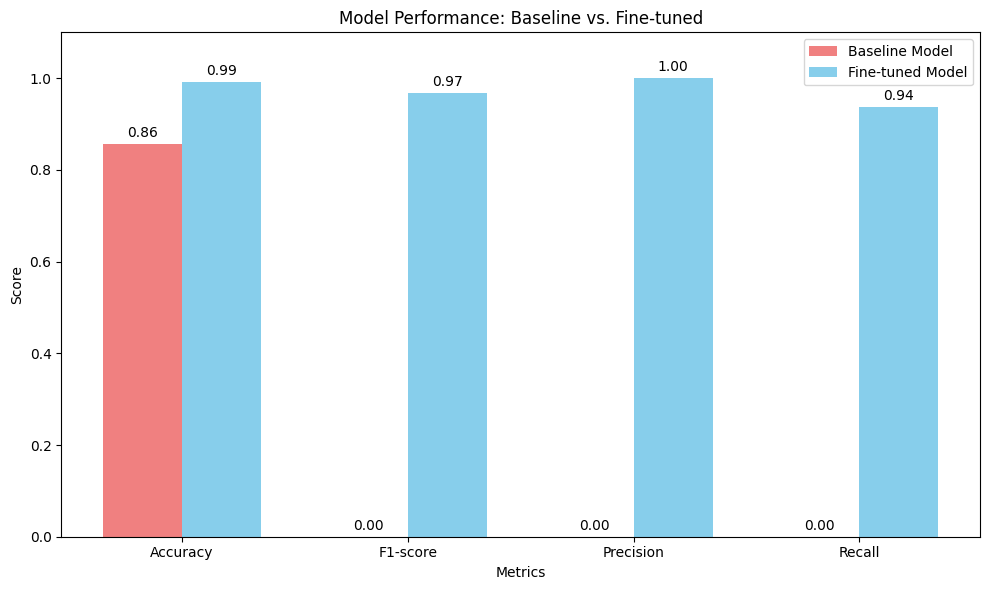

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Extract metrics for baseline and fine-tuned models
metrics_data = {
    'Metric': ['Accuracy', 'F1-score', 'Precision', 'Recall'],
    'Baseline Model': [
        baseline_metrics.get('eval_accuracy'),
        baseline_metrics.get('eval_f1'),
        baseline_metrics.get('eval_precision'),
        baseline_metrics.get('eval_recall')
    ],
    'Fine-tuned Model': [
        fined_tuned_metrics.get('eval_accuracy'),
        fined_tuned_metrics.get('eval_f1'),
        fined_tuned_metrics.get('eval_precision'),
        fined_tuned_metrics.get('eval_recall')
    ]
}

df_metrics = pd.DataFrame(metrics_data)

# Set the position of the bars on the x-axis
x = np.arange(len(df_metrics['Metric']))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the bars
rects1 = ax.bar(x - width/2, df_metrics['Baseline Model'], width, label='Baseline Model', color='lightcoral')
rects2 = ax.bar(x + width/2, df_metrics['Fine-tuned Model'], width, label='Fine-tuned Model', color='skyblue')

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Model Performance: Baseline vs. Fine-tuned')
ax.set_xticks(x)
ax.set_xticklabels(df_metrics['Metric'])
ax.legend()
ax.set_ylim(0, 1.1) # Set y-axis limit from 0 to 1 for scores

# Add value labels on top of the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()
